## Nested Logit

In [1]:
import pandas as pd
import pymc as pm
import patsy
import numpy as np
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../..')

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv('../../../../data/choice_wide_heating.csv')
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


## Single Layer Nesting

In [3]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income ', 
                    'ec ~ ic_ec + oc_ec | income ',
                    'gr ~ ic_gr + oc_gr | income ', 
                    'er ~ ic_er + oc_er | income ', 
                    'hp ~ ic_hp + oc_hp | income ']


nesting_structure = {'central': ['gc', 'ec'], 
                     'room': ['hp', 'gr', 'er']}


nstL_1 = NestedLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc'], nesting_structure=nesting_structure)
nstL_1

In [4]:
X, F, y = nstL_1.preprocess_model_data(df, utility_formulas)
print(X.shape)
F.shape

(900, 5, 2)


In [5]:
coords = nstL_1.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room'],
 'obs': range(0, 900)}

In [6]:
nest_indices = nstL_1.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])}}

In [7]:
lambda_lkup = nstL_1.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1}

In [8]:
nstL_1.build_model(X, F, y)

                alphas ~ Normal(0, 1)
                 betas ~ Normal(0, 1)
          lambda_nests ~ Beta(2, 2)
          betas_fixed_ ~ Normal(0, 1)
           betas_fixed ~ Deterministic(f(betas_fixed_))
                     U ~ Deterministic(f(betas, alphas, betas_fixed_))
beta_fixed_top_central ~ Deterministic(f(betas_fixed_))
     p_y_given_central ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
             I_central ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
   beta_fixed_top_room ~ Deterministic(f(betas_fixed_))
        p_y_given_room ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
                I_room ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
             denom_top ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
             P_central ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
                P_room ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
        prod_cen

In [9]:
nstL_1.sample()

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [10]:
az.summary(nstL_1.idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.003,-0.000,0.000,0.000,3701.0,3139.0,1.0
betas[oc],-0.005,0.001,-0.008,-0.003,0.000,0.000,2953.0,2473.0,1.0
alphas[gc],0.059,0.770,-1.446,1.417,0.016,0.014,2376.0,2124.0,1.0
alphas[ec],-0.086,0.766,-1.501,1.394,0.016,0.013,2294.0,2406.0,1.0
alphas[gr],0.545,0.313,-0.045,1.118,0.007,0.005,2111.0,2506.0,1.0
alphas[er],1.627,0.421,0.826,2.382,0.009,0.006,2023.0,2440.0,1.0
alphas[hp],-0.027,0.998,-1.757,2.005,0.018,0.017,3211.0,2399.0,1.0
"betas_fixed[gc, income]",-0.104,0.282,-0.707,0.198,0.013,0.017,837.0,625.0,1.0
"betas_fixed[ec, income]",-0.098,0.289,-0.714,0.258,0.013,0.017,891.0,638.0,1.0
"betas_fixed[gr, income]",-0.104,0.059,-0.217,0.003,0.001,0.001,1937.0,2333.0,1.0


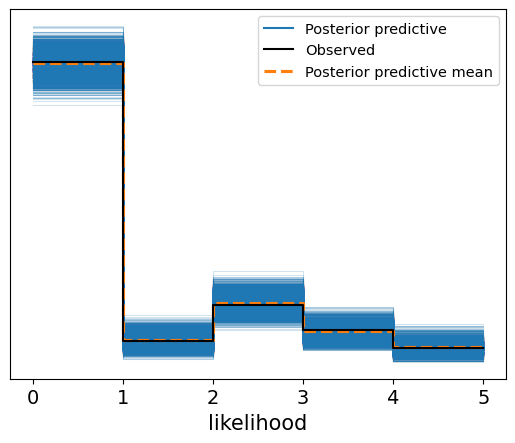

In [11]:
az.plot_ppc(nstL_1.idata);

## Two Layer Nesting


In [12]:
utility_formulas = ['gc ~ ic_gc + oc_gc | income ', 
                    'ec ~ ic_ec + oc_ec | income ',
                    'gr ~ ic_gr + oc_gr | income ', 
                    'er ~ ic_er + oc_er | income ', 
                    'hp ~ ic_hp + oc_hp | income ']

nesting_structure = {'central': ['gc', 'ec'], 
                     'room': {'hp': ['hp'], 'r': ['gr', 'er']}}

nstL_2 = NestedLogit(df, utility_formulas, 'depvar', covariates=['ic', 'oc'], nesting_structure=nesting_structure)
nstL_2

In [13]:
X, F, y = nstL_2.preprocess_model_data(df, utility_formulas)
print(X.shape)
F.shape

(900, 5, 2)


In [14]:
coords = nstL_2.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': ['income'],
 'nests': ['central', 'room', 'room_hp', 'room_r'],
 'obs': range(0, 900)}

In [15]:
nest_indices = nstL_2.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])},
 'mid': {'room_hp': [4], 'room_r': [2, 3]}}

In [16]:
lambda_lkup = nstL_2.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1, 'room_hp': 2, 'room_r': 3}

In [17]:
nstL_2.build_model(X, F, y)

                 alphas ~ Normal(0, 1)
                  betas ~ Normal(0, 1)
           lambda_nests ~ Beta(2, 2)
           betas_fixed_ ~ Normal(0, 1)
            betas_fixed ~ Deterministic(f(betas_fixed_))
                      U ~ Deterministic(f(betas, alphas, betas_fixed_))
 beta_fixed_mid_room_hp ~ Deterministic(f(betas_fixed_))
      p_y_given_room_hp ~ Deterministic(f(betas, alphas, betas_fixed_))
              I_room_hp ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
  beta_fixed_mid_room_r ~ Deterministic(f(betas_fixed_))
       p_y_given_room_r ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
               I_room_r ~ Deterministic(f(lambda_nests, betas, alphas, betas_fixed_))
              denom_mid ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
              P_room_hp ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
               P_room_r ~ Deterministic(f(lambda_nests, betas_fixed_, betas, alphas))
          prod_

In [18]:
nstL_2.sample()

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [likelihood]


Output()

In [19]:
az.summary(nstL_2.idata, var_names=['betas', 'alphas', 'betas_fixed'])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.003,0.001,-0.004,-0.001,0.000,0.000,3703.0,3243.0,1.00
betas[oc],-0.006,0.001,-0.009,-0.004,0.000,0.000,4890.0,3432.0,1.00
alphas[gc],-0.126,0.771,-1.526,1.370,0.015,0.013,2564.0,2344.0,1.00
alphas[ec],0.097,0.777,-1.342,1.593,0.015,0.015,2582.0,2368.0,1.00
alphas[gr],-0.659,0.762,-2.035,0.834,0.015,0.011,2657.0,2848.0,1.00
alphas[er],0.640,0.757,-0.965,1.895,0.014,0.012,2791.0,2557.0,1.00
alphas[hp],0.015,0.985,-1.926,1.758,0.016,0.017,3853.0,2600.0,1.00
"betas_fixed[gc, income]",-0.553,0.441,-1.354,0.138,0.014,0.008,1110.0,1814.0,1.00
"betas_fixed[ec, income]",-0.544,0.443,-1.394,0.128,0.013,0.008,1161.0,1754.0,1.00
"betas_fixed[gr, income]",-0.370,0.286,-0.880,0.037,0.010,0.015,1113.0,957.0,1.01


In [20]:
compare_df = az.compare({'1 level': nstL_1.idata, '2 level': nstL_2.idata})
compare_df

TypeError: Encountered error in ELPD computation of compare.

array([<Axes: xlabel='likelihood'>], dtype=object)

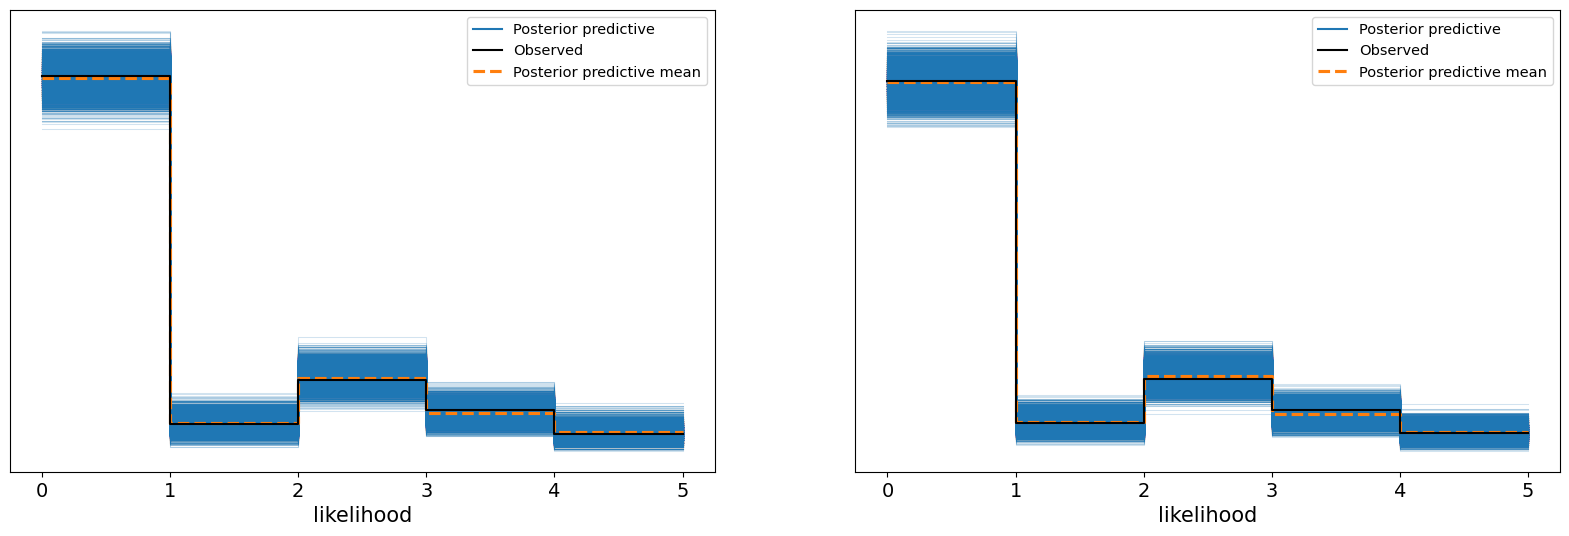

In [21]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
axs = axs.flatten()
az.plot_ppc(nstL_1.idata, ax=axs[0])
az.plot_ppc(nstL_2.idata, ax = axs[1])

## Making Interventions



In [22]:
new_policy_df = df.copy()
new_policy_df[['ic_ec', 'ic_er']] = new_policy_df[['ic_ec', 'ic_er']]*1.5

idata_new_policy_1 = nstL_1.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_2 = nstL_2.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_1

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [23]:
change_df_1 = nstL_1.calculate_share_change(nstL_1.idata, nstL_1.intervention_idata)
change_df_1

,policy_share,new_policy_share,relative_change
product,,,
gc,0.634122,0.661243,0.042770
ec,0.072193,0.040331,-0.441344
gr,0.146810,0.183088,0.247113
er,0.089462,0.043302,-0.515978
hp,0.057414,0.072036,0.254690


In [24]:
change_df_2 = nstL_2.calculate_share_change(nstL_2.idata, nstL_2.intervention_idata)
change_df_2

,policy_share,new_policy_share,relative_change
product,,,
gc,0.635005,0.672712,0.059381
ec,0.072622,0.023670,-0.674064
gr,0.148519,0.212216,0.428882
er,0.087069,0.031940,-0.633159
hp,0.056786,0.059462,0.047117


## Substitution Patterns

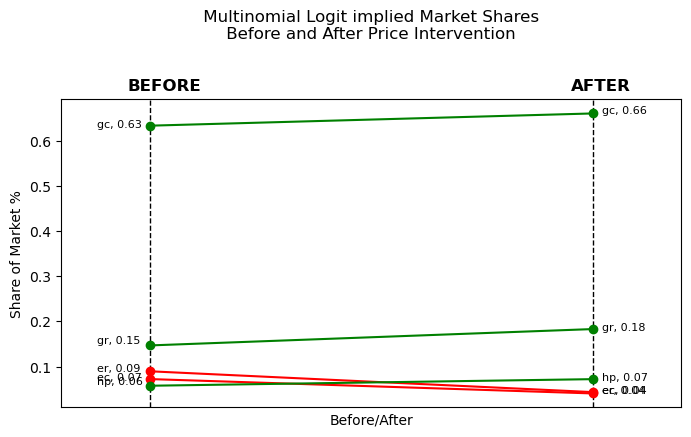

In [25]:
fig = nstL_1.make_change_plot(change_df=change_df_1)

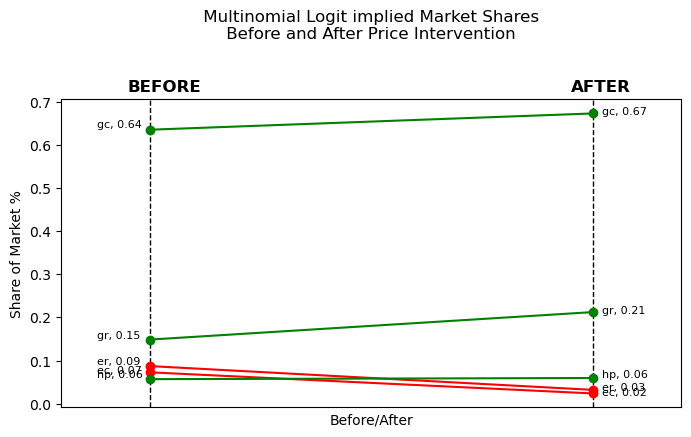

In [26]:
fig = nstL_2.make_change_plot(change_df=change_df_2)

## Experimental

In [27]:
N = df.shape[0]

def make_exp_nest(U, W, betas_fixed, lambdas_nests, nest, level='top'):
    if '_' in nest:
        parent, child = nest.split('_')
    else: 
        parent = None
    y_nest = U[:, nest_indices[level][nest]]
    betas_fixed_ = betas_fixed[nest_indices[level][nest], :]
    betas_fixed_ = pm.Deterministic(f'beta_fixed_{level}_{nest}', pt.set_subtensor(betas_fixed_[-1, :], 0))
    
    w_nest = pm.math.dot(W, betas_fixed_.T)
    if len(nest_indices[level][nest]) > 1:
        max_y_nest = pm.math.max(y_nest, axis=0)
        P_y_given_nest = pm.Deterministic(
            f"p_y_given_{nest}",
            pm.math.softmax(y_nest / lambdas_nests[lambda_lkup[nest]], axis=1),
        )
    else:
        max_y_nest = pm.math.max(y_nest)
        ones = pm.math.ones((N, 1))
        P_y_given_nest = pm.Deterministic(f"p_y_given_{nest}", ones)
    if parent is None:
        lambda_ = lambdas_nests[lambda_lkup[nest]]
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambda_)
        )
        W_nest = w_nest + I_nest * lambda_
    else:
        l1 = lambdas_nests[lambda_lkup[nest]]
        l2 = lambdas_nests[lambda_lkup[parent]]
        lambdas_ = l1 * l2
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambdas_)
        )
        W_nest = w_nest + I_nest * (lambdas_)

    exp_W_nest = pm.math.exp(W_nest)
    return exp_W_nest, P_y_given_nest


def make_P_nest(U, W, betas_fixed, lambdas_nests, level):
    conditional_probs = {}
    for n in nest_indices[level].keys():
        exp_W_nest, P_y_given_nest = make_exp_nest(U, W, betas_fixed, 
            lambdas_nests, n, level)
        if W is None:
            conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}
        else: 
            exp_W_nest = pm.math.sum(exp_W_nest, axis=1)
            conditional_probs[n] = {'exp': exp_W_nest, 'P_y_given': P_y_given_nest}

    
    denom = pm.Deterministic(f'denom_{level}', pm.math.sum([conditional_probs[n]['exp'] for n in nest_indices[level].keys()], axis=0))
    nest_probs = {}
    for n in nest_indices[level].keys():
        P_nest = pm.Deterministic(f'P_{n}', (conditional_probs[n]['exp'] / denom))
        nest_probs[n] = P_nest
    return conditional_probs, nest_probs
    

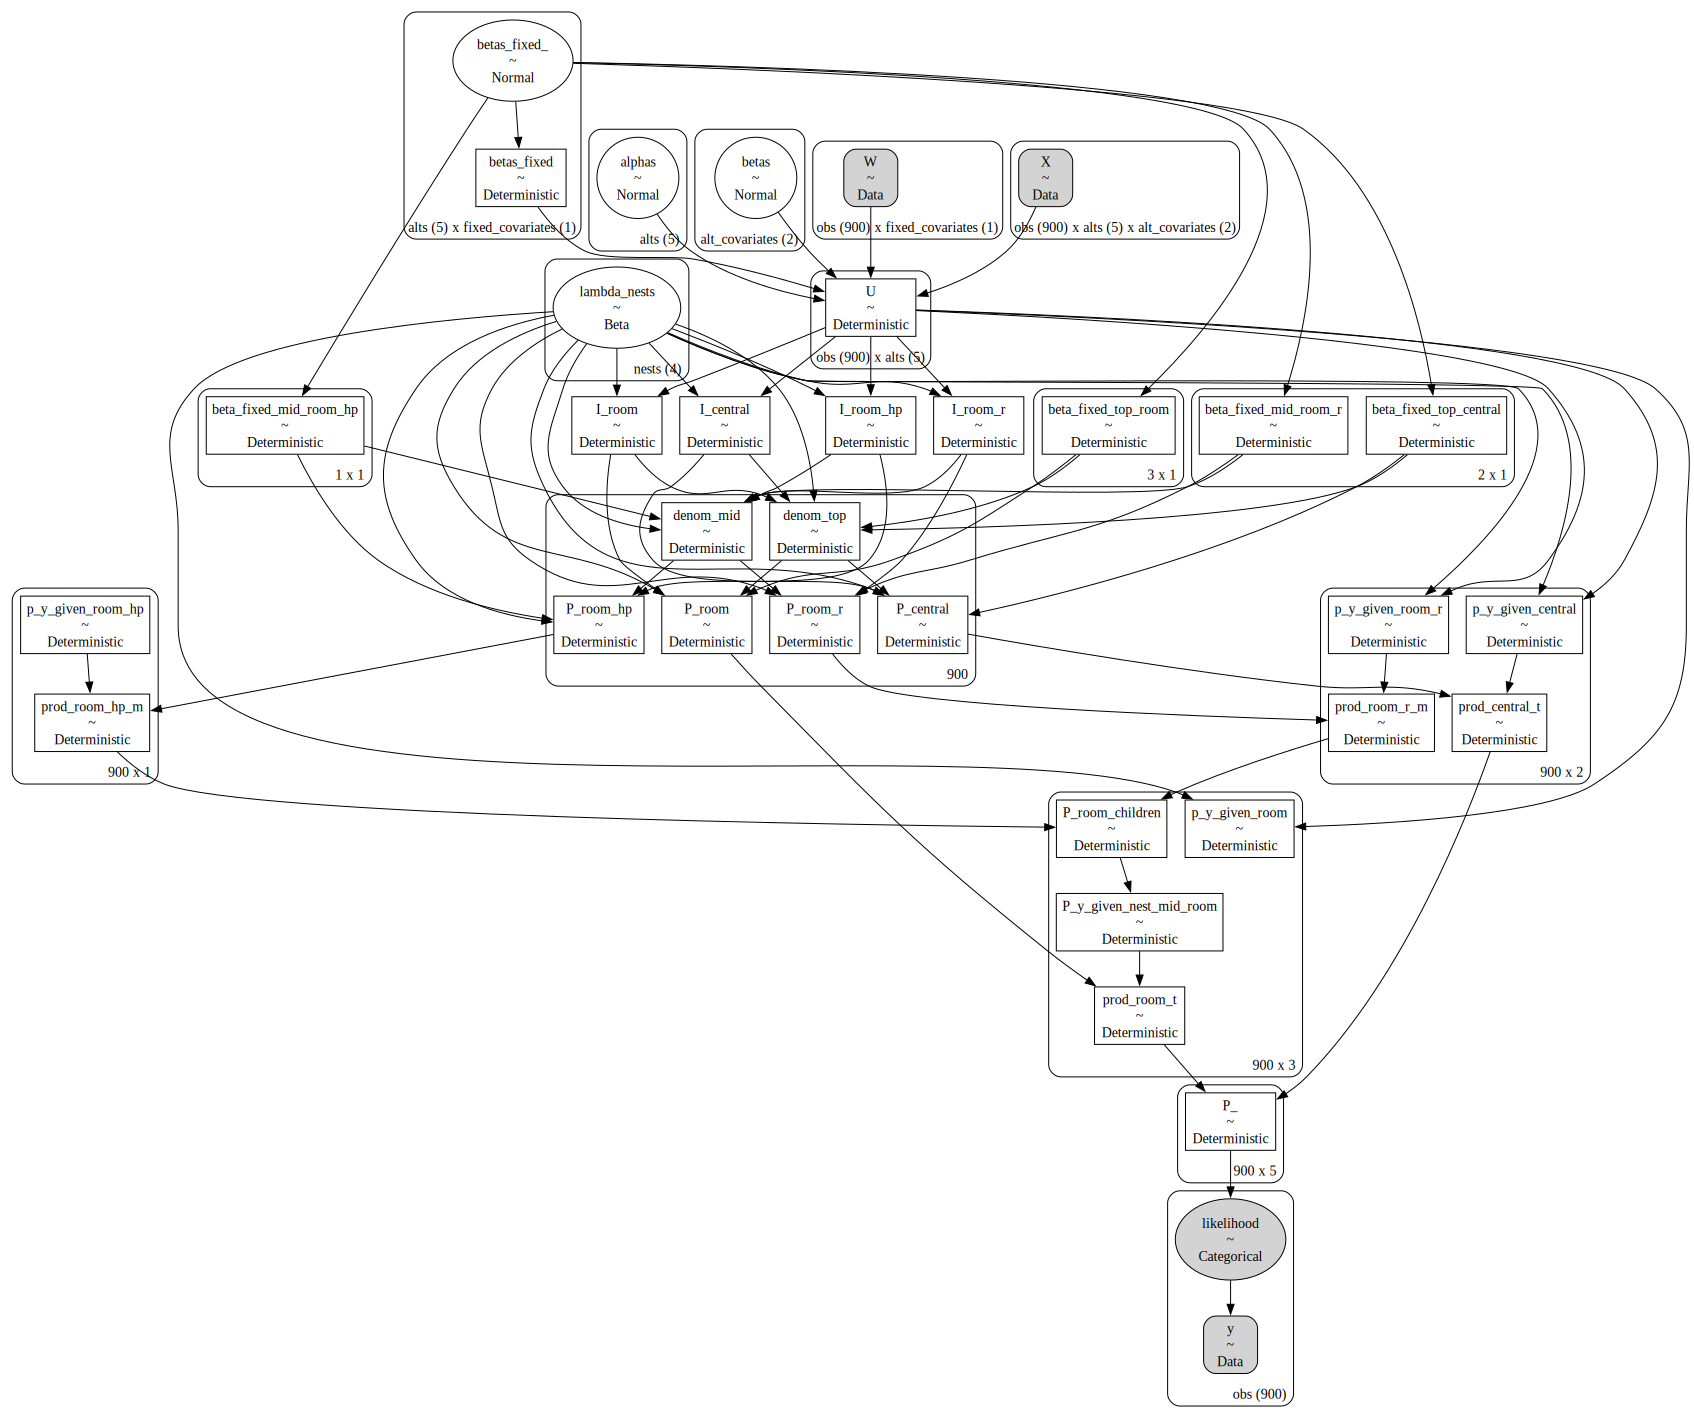

In [28]:
def make_model(X, y, W, N=900):
    with pm.Model(coords=coords) as model:
        alphas = pm.Normal('alphas', 0, 1, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('alt_covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')
        
        if W is None:
            w_nest = pm.math.zeros((len(coords['obs']), 
                                    len(coords['alts'])))
        else: 
            W_data = pm.Data('W', W, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                    dims=('alts','fixed_covariates'))
            w_nest = pm.math.dot(W_data, betas_fixed.T)
        X_data = pm.Data('X', X,  dims=('obs', 'alts', 'alt_covariates'))
        y_data = pm.Data('y', y, dims='obs')

        # Compute utility as a dot product
        alphas = pt.set_subtensor(alphas[-1], 0)
        u = alphas + pm.math.dot(X_data, betas)
        U = pm.Deterministic('U', w_nest + u, dims=('obs', 'alts'))
        
        # ## Mid Level
        if 'mid' in nest_indices.keys():
            cond_prob_m, nest_prob_m = make_P_nest(U, W, betas_fixed_, lambdas_nests, 'mid')
    
            ## Construct Paths Bottom -> Up
            child_nests = {}
            path_prods_m = {}
            ordered = [(key, min(vals)) for key, vals in nest_indices['mid'].items()]
            middle_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
            for idx, n in enumerate(middle_nests):
                is_last = idx == len(middle_nests) - 1
                parent, child = n.split('_')
                P_nest = nest_prob_m[n]
                P_y_given_nest = cond_prob_m[n]['P_y_given']
                prod = pm.Deterministic(f'prod_{n}_m', (P_nest[:, pt.newaxis]*P_y_given_nest))
                if parent in path_prods_m:
                    path_prods_m[parent].append(prod)
                else:
                    path_prods_m[parent] = []
                    path_prods_m[parent].append(prod)
                if is_last:
                    P_ = pm.Deterministic(f'P_{parent}_children',  pm.math.concatenate(path_prods_m[parent], axis=1))
                    child_nests[parent] = P_
        else: 
            child_nests = {}

        ## Top Level
        cond_prob_t, nest_prob_t = make_P_nest(U, W, betas_fixed_, lambdas_nests, 'top')

        path_prods_t = []
        ordered = [(key, min(vals)) for key, vals in nest_indices['top'].items()]
        top_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
        for idx, n in enumerate(top_nests):
           P_nest = nest_prob_t[n]
           P_y_given_nest = cond_prob_t[n]['P_y_given']
           if n in child_nests:
               P_y_given_nest_mid = pm.Deterministic(f'P_y_given_nest_mid_{n}', child_nests[n])
               prod = pm.Deterministic(f'prod_{n}_t', (P_nest[:, pt.newaxis]*(P_y_given_nest_mid)))
           else:
               prod = pm.Deterministic(f'prod_{n}_t', (P_nest[:, pt.newaxis]*(P_y_given_nest)))
           path_prods_t.append(prod)
        P_ = pm.Deterministic('P_', pm.math.concatenate(path_prods_t, axis=1))
        
        choice_obs = pm.Categorical("likelihood", p=P_, observed=y_data, dims="obs")

    return model


model = make_model(X, y, W=F)
pm.model_to_graphviz(model)

## 2 Level Nesting

In [29]:
def make_nested_logit(X, y, coords, nest_indices, N, X_fixed=None):

    with pm.Model(coords=coords) as nested_model:
        alphas = pm.Normal('alphas', 0, 5, dims='alts')
        betas = pm.Normal('betas', 0, 1, dims=('covariates'))
        lambdas_nests = pm.Beta('lambda_nests', 2, 2, dims='nests')

        ## Nest Fixed values like income
        if X_fixed is None: 
            W = pm.math.zeros(N)
        else: 
            W_data = pm.Data('W', X_fixed, dims=('obs', 'fixed_covariates'))
            betas_fixed_ = pm.Normal('betas_fixed_', 0, 1, dims=('alts', 'fixed_covariates'))
            betas_fixed = pm.Deterministic('betas_fixed', pt.set_subtensor(betas_fixed_[-1, :], 0), 
                dims=('alts','fixed_covariates'))
            W = pm.Deterministic('w_nest', pm.math.dot(W_data, betas_fixed.T))

        X = pm.MutableData('X', X, dims=('obs', 'alts', 'covariates'))
        y = pm.MutableData('y', y, dims='obs')

        alphas = pt.set_subtensor(alphas[-1], 0)
        U = pm.Deterministic('U', 
            (alphas + pm.math.dot(X, betas)), 
            dims=('obs', 'alts'))

        U = pm.Deterministic('U + W', W + U)

        
        ## Create Nest Specific Probabilities
        nest_probabilities = []
        mprob_nest = {}
        for i, n in enumerate(nest_indices.keys()) :
            u = U[:, nest_indices[f'{n}']]
            y_nest = pm.Deterministic(f'y_{n}', u, 
                dims=('obs', f'{n}_alts'))
            if len(nest_indices[f'{n}']) > 1:
                max_y_nest = pm.math.max(y_nest, axis=0)
                s = pm.math.softmax(y_nest / lambdas_nests[i], axis=1)
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', s, 
                    dims = ('obs', f'{n}_alts')) 
            else: 
                max_y_nest = pm.math.max(y_nest)
                ones = pm.math.ones((N, 1))
                P_y_given_nest = pm.Deterministic(f'p_y_given_{n}', ones)
            lsexp = pm.math.logsumexp((y_nest - max_y_nest)/lambdas_nests[i])
            I_nest = pm.Deterministic(f'I_{n}', lsexp)

            W_nest = W + I_nest*lambdas_nests[i]
            exp_W_nest = pm.Deterministic(f'exp_W_{n}', pm.math.exp(W_nest))
            nest_probabilities.append(exp_W_nest)
            mprob_nest[n] = P_y_given_nest

        ## Define Conditional Probability
        final_stack = []
        for n, np in zip(nest_indices.keys(), nest_probabilities): 
            P_nest =  pm.Deterministic(f'P_{n}', 
                (np / pm.math.sum(nest_probabilities, axis=0)), 
                dims=('obs', 'alts'))
            prod = (mprob_nest[n]*P_nest[:, nest_indices[n]])
            P_y_nest = pm.Deterministic(f'P_y_{n}', prod)
            final_stack.append(P_y_nest)

        # Stack into probability matrix
        final_stack = pm.math.concatenate(final_stack, axis=1)
        p_ = pm.Deterministic('p', final_stack, dims=('obs', 'alts'))
        
        choice_obs = pm.Categorical("likelihood", p=p_, observed=y, dims="obs")

    return nested_model

nested_model = make_nested_logit(X, y, coords, nest_indices, N, F)
pm.model_to_graphviz(nested_model)


KeyError: "Dimensions {'covariates'} are unknown to the model and cannot be used to specify a `shape`."